<h1 align="center">Model Evaluation</h1>

<h4 style="text-align:center"><a href = 'https://github.com/virchan' style='text-align:center'>https://github.com/virchan</a></h4> 

<h2>Abstract</h2>

In this notebook, we present a detailed analysis of predictive model evaluation using the Kaggle competition "Titanic - Machine Learning from Disaster". By training and testing nine machine learning models on Kaggle's dataset, we strive to predict the survival of Titanic passengers accurately. Through a comprehensive evaluation process involving accuracy comparison and overfitting analysis, we aim to identify the top-performing model.

<h2>Introduction</h2>

Welcome to this notebook where we embark on an exploration of the Kaggle competition __Titanic - Machine Learning from Disaster ([Kaggle link](https://www.kaggle.com/competitions/titanic/))__. Our primary objective is to demonstrate the evaluation of predictive models using this competition as a platform. We have trained and tested nine machine learning models on a dataset provided by Kaggle, with the aim of predicting the survival of Titanic passengers. These models include a Dummy Classifier (`dummy`), a Decision Tree Classifier (`tree`), a Random Forest Classifier (`forest`), a Support Vector Classifier (`support_vector`), a Feedforward Neural Network (`neural_network`), a Logistic Regressor (`logistic`), a Gaussian Naive Bayes Classifier (`gaussian_NB`), a Bernoulli Naive Bayes Classifier (`bernoulli_NB`), and an Adaboost Classifier (`adaboost`). 

During the initial model training stage (details available in the `demo_ML_models.ipynb` file), we collected training and testing predictions for each model. Our main focus is to identify the best-performing model for the Kaggle competition by leveraging these predictions, which are provided in the `csv/data/predictions.csv` file. This evaluation process mirrors real-life scenarios, where models undergo thorough evaluation prior their online deployment.

The evaluation procedure involves comparing the training and testing accuracies of each model to detect signs of overfitting. Hypothesis testing is employed for this purpose. Subsequently, we select the models that exhibit the highest testing accuracies while passing the overfitting test. In case of a tie, we employ post-hoc analyses, such as analyzing confusion matrices, to determine the superior model. Finally, we compare our findings with the Kaggle submission accuracies to validate whether our recommended choice emerges as the top-performing model in the Kaggle competition or if it indicates overfitting.

This document serves as a supplement to the general report provided in the `README.md` file. It was originally intended as one of the [author](https://github.com/virchan)'s portfolio projects to share insights into data science and machine learning. As the content started to delve into more abstract and technical aspects, it was deemed appropriate to separate it from the main report.

<h2>Initiating the Data</h2>

To kickstart our analysis, we import the necessary Python libraries.

In [1]:
%matplotlib inline

from titanic_ml_classes.titanic_evaluation_helpers import titanic_evaluation_helpers as helpers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

One such library is `titanic_evaluation_helpers` (`helpers`), which comprises custom Python functions specifically designed to streamline our in-depth analysis. For instance, the `helpers.plot_accuracies` function aids in generating visualizations of model accuracies, while the `helpers.get_confusion_matrices` function efficiently organizes model performance data.

Next, we import the dataset into the `predictions_df` dataframe. It's important to mention that the `csv/data/predictions.csv` file consolidates the predictions from both the `csv/data/train_predictions.csv` and `csv/data/test_predictions.csv` files, which were generated during the previous model training stage.

In [2]:
# Load the data
predictions_df: pd.DataFrame = pd.read_csv('csv/data/predictions.csv')

# Print
print('Here is all predictions from each model.')
display(predictions_df.head())

Here is all predictions from each model.


,PassengerId,y_true,dummy,tree,forest,support_vector,neural_network,logistic,gaussian_NB,bernoulli_NB,adaboost,train
0,659,0,0,0,0,0,0,0,0,0,0,1
1,489,0,0,0,0,0,0,0,0,0,0,1
2,169,0,0,0,0,0,0,0,0,0,0,1
3,828,1,0,1,1,1,1,1,1,1,1,1
4,56,1,0,0,0,0,0,0,1,1,0,1


Within the `predictions_df` dataframe, the `predictions_df[model]` column represents a binary vector that indicates the predicted label (i.e., whether a passenger is predicted to have survived) by the `model` model. The true labels are provided in the `predictions_df['y_true']` column, while the `predictions_df['train']` column signifies whether a given sample is from the training phase or not.

In real-world scenarios, selecting an appropriate evaluation metric is a crucial aspect of model evaluation. As the Kaggle competition evaluates using accuracy scores, we adopt this metric as the preferred choice for both the training and testing stages. Leveraging the competition's evaluation system simplifies the model evaluation process by providing a standardized metric for comparison and assessment.

<h2>Accuracy For Each Model</h2>

The accuracy of a classifier is derived from the following formula

<img src = "https://latex.codecogs.com/svg.image?\mbox{Accuracy}&space;=&space;\frac{TP&space;&plus;&space;TN}{TP&space;&plus;&space;FP&space;&plus;&space;FN&space;&plus;&space;TN},"/>

where TP, TN, FP, and FN represent the numbers of True Positives, True Negatives, False Positives, and False Negatives, respectively. To compute the accruacy scores, we employ the powerful `helpers.get_confusion_matrices` function. This function efficiently generates a dataframe containing the training and testing confusion matrices for each model.

<!-- last checked: 20230612 -->

In [3]:
confusion_matrices_df: pd.DataFrame = helpers.get_confusion_matrices(predictions_df)
    
print('This is the dataframe of training and testing confusion matrices for each model.')
display(confusion_matrices_df)

This is the dataframe of training and testing confusion matrices for each model.


,model,train,TN,FP,FN,TP
0,dummy,1,384,0,239,0
1,dummy,0,165,0,103,0
2,tree,1,370,14,52,187
3,tree,0,142,23,32,71
4,forest,1,362,22,44,195
5,forest,0,143,22,26,77
6,support_vector,1,353,31,54,185
7,support_vector,0,143,22,25,78
8,neural_network,1,373,11,62,177
9,neural_network,0,154,11,34,69


Leveraging the vectorization feature of the `pandas` library, the metrics are computed using `lambda` functions. This approach proves particularly beneficial when calculating confusion matrix metrics that are not directly available from the `scikit-learn` library, as we will explore further in the subsequent sections.

In [4]:
confusion_matrices_df['accuracy'] = confusion_matrices_df.agg(lambda row: (row['TP'] +row['TN']) / (row['TP'] +row['TN'] + row['FP'] +row['FN']), 
                                                              axis = 1)

print('This is the dataframe of training and testing accuracies for each model.')
display(confusion_matrices_df[['model', 'train', 'accuracy']])

This is the dataframe of training and testing accuracies for each model.


,model,train,accuracy
0,dummy,1,0.616372
1,dummy,0,0.615672
2,tree,1,0.894061
3,tree,0,0.794776
4,forest,1,0.894061
5,forest,0,0.820896
6,support_vector,1,0.863563
7,support_vector,0,0.824627
8,neural_network,1,0.882825
9,neural_network,0,0.832090


The resulting dataframe is structured in a manner that facilitates the creation of data visuals using the `seaborn` library.

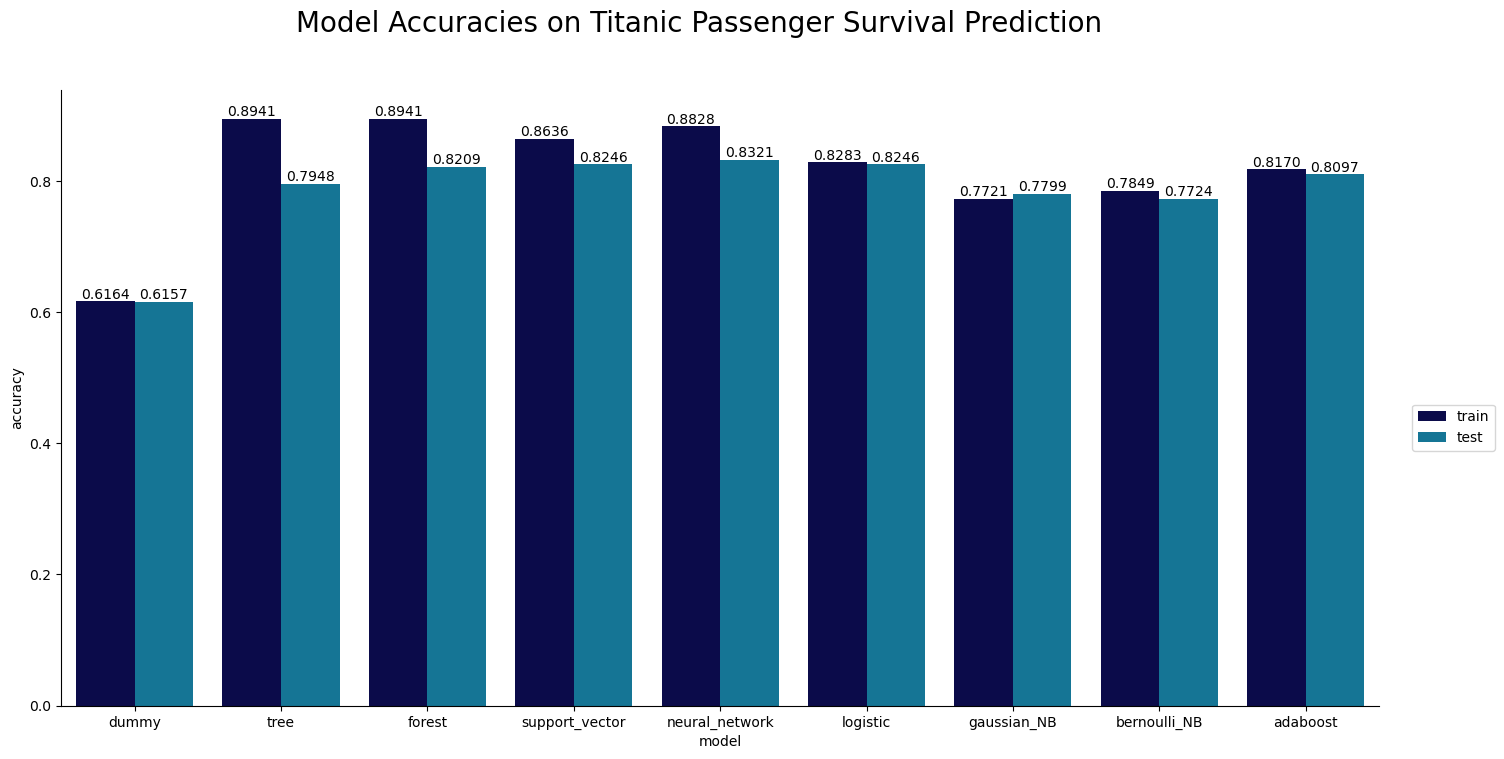

In [5]:
helpers.plot_accuracies(confusion_matrices_df)

The `neural_network` model achieves the highest testing accuracy of 0.8320, representing a marginal improvement of just 0.91% over the `support_vector` and `logistic` models, which obtained scores of 0.8246. Following closely in the third position is the `forest` model with an accuracy of 0.8209, followed by `adaboost` (0.8097), `gaussian_NB` (0.7799), and `bernoulli_NB` (0.7724). It is noteworthy that the `dummy` classifier exhibits the lowest performance, scoring only 0.6157.

These results prompt the question of whether the `neural_network` model will outperform the others in the upcoming Kaggle competition. However, it is important to consider the significant disparity between the training and testing accuracies, observed not only in the `neural_network` model, but also in the `tree` and `forest` models. Thus, evaluating for overfitting becomes a critical step in assessing the models. Therefore, detecting and mitigating overfitting should be the foremost priority in the model evaluation process.

<h2>Determine Overfitting with Hypothesis Testing and Confidence Intervals</h2>

<!-- The accuracy score is the gold standard for evaluating model performance in this Kaggle competition. Therefore, in our case, the presence of overfitting should be determined based on the comparison between training and testing accuracies. It is essential to thoroughly analyze and compare these accuracies for each model to draw conclusive insights. In addition to the aforementioned formula, we can also compute accuracy by counting the number of correctly predicted instances, as demonstrated in the `correct_predictions` dataframe below. -->

The accuracy score is the gold standard for evaluating model performance in this Kaggle competition. Therefore, in our case, the presence of overfitting should be determined based on the comparison between training and testing accuracies. It is essential to thoroughly analyze and compare these accuracies for each model to draw conclusive insights. In addition to the aforementioned formula, we can also compute accuracy by counting the number of correctly predicted instances, as demonstrated in the `correct_predictions` dataframe below.

In [6]:
# Create a dataframe indicating if a sample is
# correctly predicted.

correct_predictions: pd.DataFrame = predictions_df[['PassengerId', 'train']].copy()
    
for model in predictions_df.drop(['PassengerId', 'y_true', 'train'], axis = 1).columns:
    correct_predictions[model] = (predictions_df[model] == predictions_df['y_true']).astype(int)

print('Here is the result of correct predictions.')
display(correct_predictions.head())

Here is the result of correct predictions.


,PassengerId,train,dummy,tree,forest,support_vector,neural_network,logistic,gaussian_NB,bernoulli_NB,adaboost
0,659,1,1,1,1,1,1,1,1,1,1
1,489,1,1,1,1,1,1,1,1,1,1
2,169,1,1,1,1,1,1,1,1,1,1
3,828,1,0,1,1,1,1,1,1,1,1
4,56,1,0,0,0,0,0,0,1,1,0


In the `correct_predictions[model]` column of the dataframe, each entry represents whether a sample is correctly classified by the `model` model. By using the pandas operations `.sum` and `.count`, we can determine the number of correctly predicted instances by the `model` model, as well as the total number of samples. Therefore, the accuracy score of the `model` model can be expressed as a proportion:

<img src = "https://latex.codecogs.com/gif.image?\dpi{110}\mbox{Accuracy}&space;=&space;&space;\frac{\texttt{correct\char`_predictions[model].sum()}}{\texttt{correct\char`_predictions[model].count()}},"/>

Mathematically, the `correct_predictions[model]` column represents a series of independent Bernoulli trials,  with each trial having the model's accuracy as the probability of success. According to the de Moivre-Laplace Theorem ([Wikipedia link](https://en.wikipedia.org/wiki/De_Moivre%E2%80%93Laplace_theorem)), these model accuracies can be approximated using normal distributions. Since we are comparing two proportions, both of which can be approximated by normal distributions, the Two Proportion Z-Test is the appropriate hypothesis testing method for this scenario.

Are the training and testing accuracies comparable? For each model, we test for a difference in proportions:
* the null hypothesis for the test is that the proportions are the same, while
* the alternative hypothesis is that the proportions are not the same. 

We select a significance level of `alpha = 0.05` for the hypothesis test. The test can be performed using two approaches: the p-value approach and the critical z-score approach. In the p-value approach, we reject the null hypothesis if the p-value is less than `alpha`, whereas in the critical z-score approach, we reject the null hypothesis if the z-score is greater than `critical z-score = 1.96`.

To perform the hypothesis testing, we make use of the powerful `helpers.two_proportion_Z_test` function from our `helpers` library. This function returns the conclusions of the hypothesis tests as a dataframe.

In [7]:
Z_test_df: pd.DataFrame = helpers.two_proportion_Z_test(correct_predictions, 
                                                        alpha_ = 0.05
                                                       )
    
display(Z_test_df)

Performing (Two-tailed) Two Proportion Z-Test on Training and Testing Accuracies
with signaficant level alpha = 0.05.
The null hypothesis is training and testing accuracies are the same.
The alternative hypothesis is training and testing accuracies are not the same.


Hypothesis Testing is completed!


,model,accuracy_train,accuracy_test,CI_train,CI_test,z_score,p_value,reject_null
0,dummy,0.616372,0.615672,"(0.5781884653026746, 0.6545563180039063)","(0.5574336374534516, 0.6739096461286378)",0.019725,0.984263,0
1,tree,0.894061,0.794776,"(0.8698943933709182, 0.9182275969982632)","(0.7464238295108234, 0.8431284092951468)",3.967303,0.000073,1
2,forest,0.894061,0.820896,"(0.8698943933709182, 0.9182275969982632)","(0.7749886337675082, 0.8668024110086113)",2.998427,0.002714,1
3,support_vector,0.863563,0.824627,"(0.8366098126511091, 0.8905169931273821)","(0.779097566449348, 0.8701561648939355)",1.500375,0.133517,0
4,neural_network,0.882825,0.832090,"(0.8575693758523778, 0.908080704404444)","(0.7873383622332597, 0.8768407422443523)",2.048950,0.040467,1
5,logistic,0.828250,0.824627,"(0.7986339676203473, 0.8578668349478709)","(0.779097566449348, 0.8701561648939355)",0.131186,0.895628,0
6,gaussian_NB,0.772071,0.779851,"(0.7391299330126365, 0.8050113189937841)","(0.7302435080957167, 0.8294579844415967)",-0.254809,0.798871,0
7,bernoulli_NB,0.784912,0.772388,"(0.7526473727280839, 0.8171760622638905)","(0.7221889528481097, 0.8225871665548753)",0.414629,0.678414,0
8,adaboost,0.817014,0.809701,"(0.7866526586214644, 0.8473762338343944)","(0.7627054968852961, 0.8566974881893307)",0.257711,0.796630,0


The `Z_test_df[reject_null]` column contains the results of the hypothesis tests. It takes the value -1 if the p-value approach disagrees with the critical z-score approach, and returns a Boolean value indicating whether the null hypothesis should be rejected. Notably, both approaches agree for every model in this case.

Based on the hypothesis test results, we reject the null hypothesis that the training and testing accuracies are the same for the `tree`, `forest`, and `neural_network` models at a confidence level of 95%. Conversely, we fail to reject the null hypothesis for the `dummy`, `support_vector`, `logistic`, `gaussian_NB`, `bernoulli_NB`, and `adaboost` models.

These findings suggest a statistically significant difference in performance between the training and testing stages for the `tree`, `forest`, and `neural_network` models. To further investigate, we examine the confidence intervals for the accuracy. These data can be accessed using the `Z_test_df[CI_train]` and `Z_test_df[CI_test]` columns. Notably, we observe that all three models have small intersection between training and testing confidence intervals, setting them apart from the rest.

To illusrate this, we compute the Jaccard index ([Wikipedia link](https://en.wikipedia.org/wiki/Jaccard_index))
<img src = "https://latex.codecogs.com/gif.image?\dpi{110}&space;J(A,&space;B)&space;=&space;\frac{\left\vert&space;A&space;\cap&space;B&space;\right\vert}{\left\vert&space;A&space;\cup&space;B&space;\right\vert}"/>

to measure the similarity between two sets. Once again, we leverage the vectorization operations provided by the `pandas` library when computing the Jaccard index with our `helpers.Jaccard_index` function.

In [8]:
# Compute the Jaccard index of 
# the training and testing intervals
Z_test_df['Jaccard'] = Z_test_df.agg(lambda row: helpers.Jaccard_index([row['CI_train'], row['CI_test']]), 
                                     axis = 1
                                    )

# Sort the Jaccard indices in accending order
display(Z_test_df[['model', 'reject_null', 'Jaccard']].sort_values(by = ['Jaccard']))

,model,reject_null,Jaccard
1,tree,1,0.000000
2,forest,1,0.000000
4,neural_network,1,0.159607
3,support_vector,0,0.301082
7,bernoulli_NB,0,0.642727
8,adaboost,0,0.646051
5,logistic,0,0.650492
0,dummy,0,0.655653
6,gaussian_NB,0,0.664030


The computation shows the `tree` and `forest` models have the lowest Jaccard index of 0. The `neural_network` model follows closely with a score of 0.1596, placing it as the first-runner up. The `support_vector` model comes in third with a Jaccard index of 0.3011, followed by `bernoulli_NB` (0.6427), `adaboost` (0.6461), `logistic` (0.6505), and `dummy` (0.6557). The `gaussian_NB` model achieves the highest Jaccard index of 0.6640.

These findings indicate a significant difference in training and testing performance, suggesting the presence of overfitting. Hence, at a 95% confidence level, the `tree`, `forest`, and `neural_network` models exhibit signs of overfitting.

While the `neural_network` model showcases the highest testing accuracy, concerns about its reliability have been raised. Consequently, it is crucial for us to shift our focus to the first-runner up model.  Our contenders for this position are the `support_vector` and `logistic` models, both achieving a testing accuracy of 0.8246. This leaves us in a situation of a tie, where further investigation is required to determine the superior candidate.

<h2>Confusion Matrices</h2>

Among the evaluated models, the `neural_network` model achieved the highest testing accuracy of 0.8320. However, despite its impressive accuracy, the model failed the overfitting test conducted in the previous section, raising concerns about its reliability. This leads us to the models with the second highest testing accuracy: the `support_vector` and the `logistic` models, both achieving a score of 0.8246. As both models passed the overfitting test, it becomes crucial to determine the superior performer. To shed light on this matter, we turn our attention to the analysis of confusion matrices.

To generate visual representations of the confusion matrices for each model, we employ the `helpers.plot_confusion_matrices` function. This function organizes four bar graphs into a 2x2 grid, mimicking a regular confusion matrix layout. Starting from the top-left corner and proceeding clockwise, the bar graphs represent the True Positives, False Positives, False Negatives, and True Negatives, respectively.

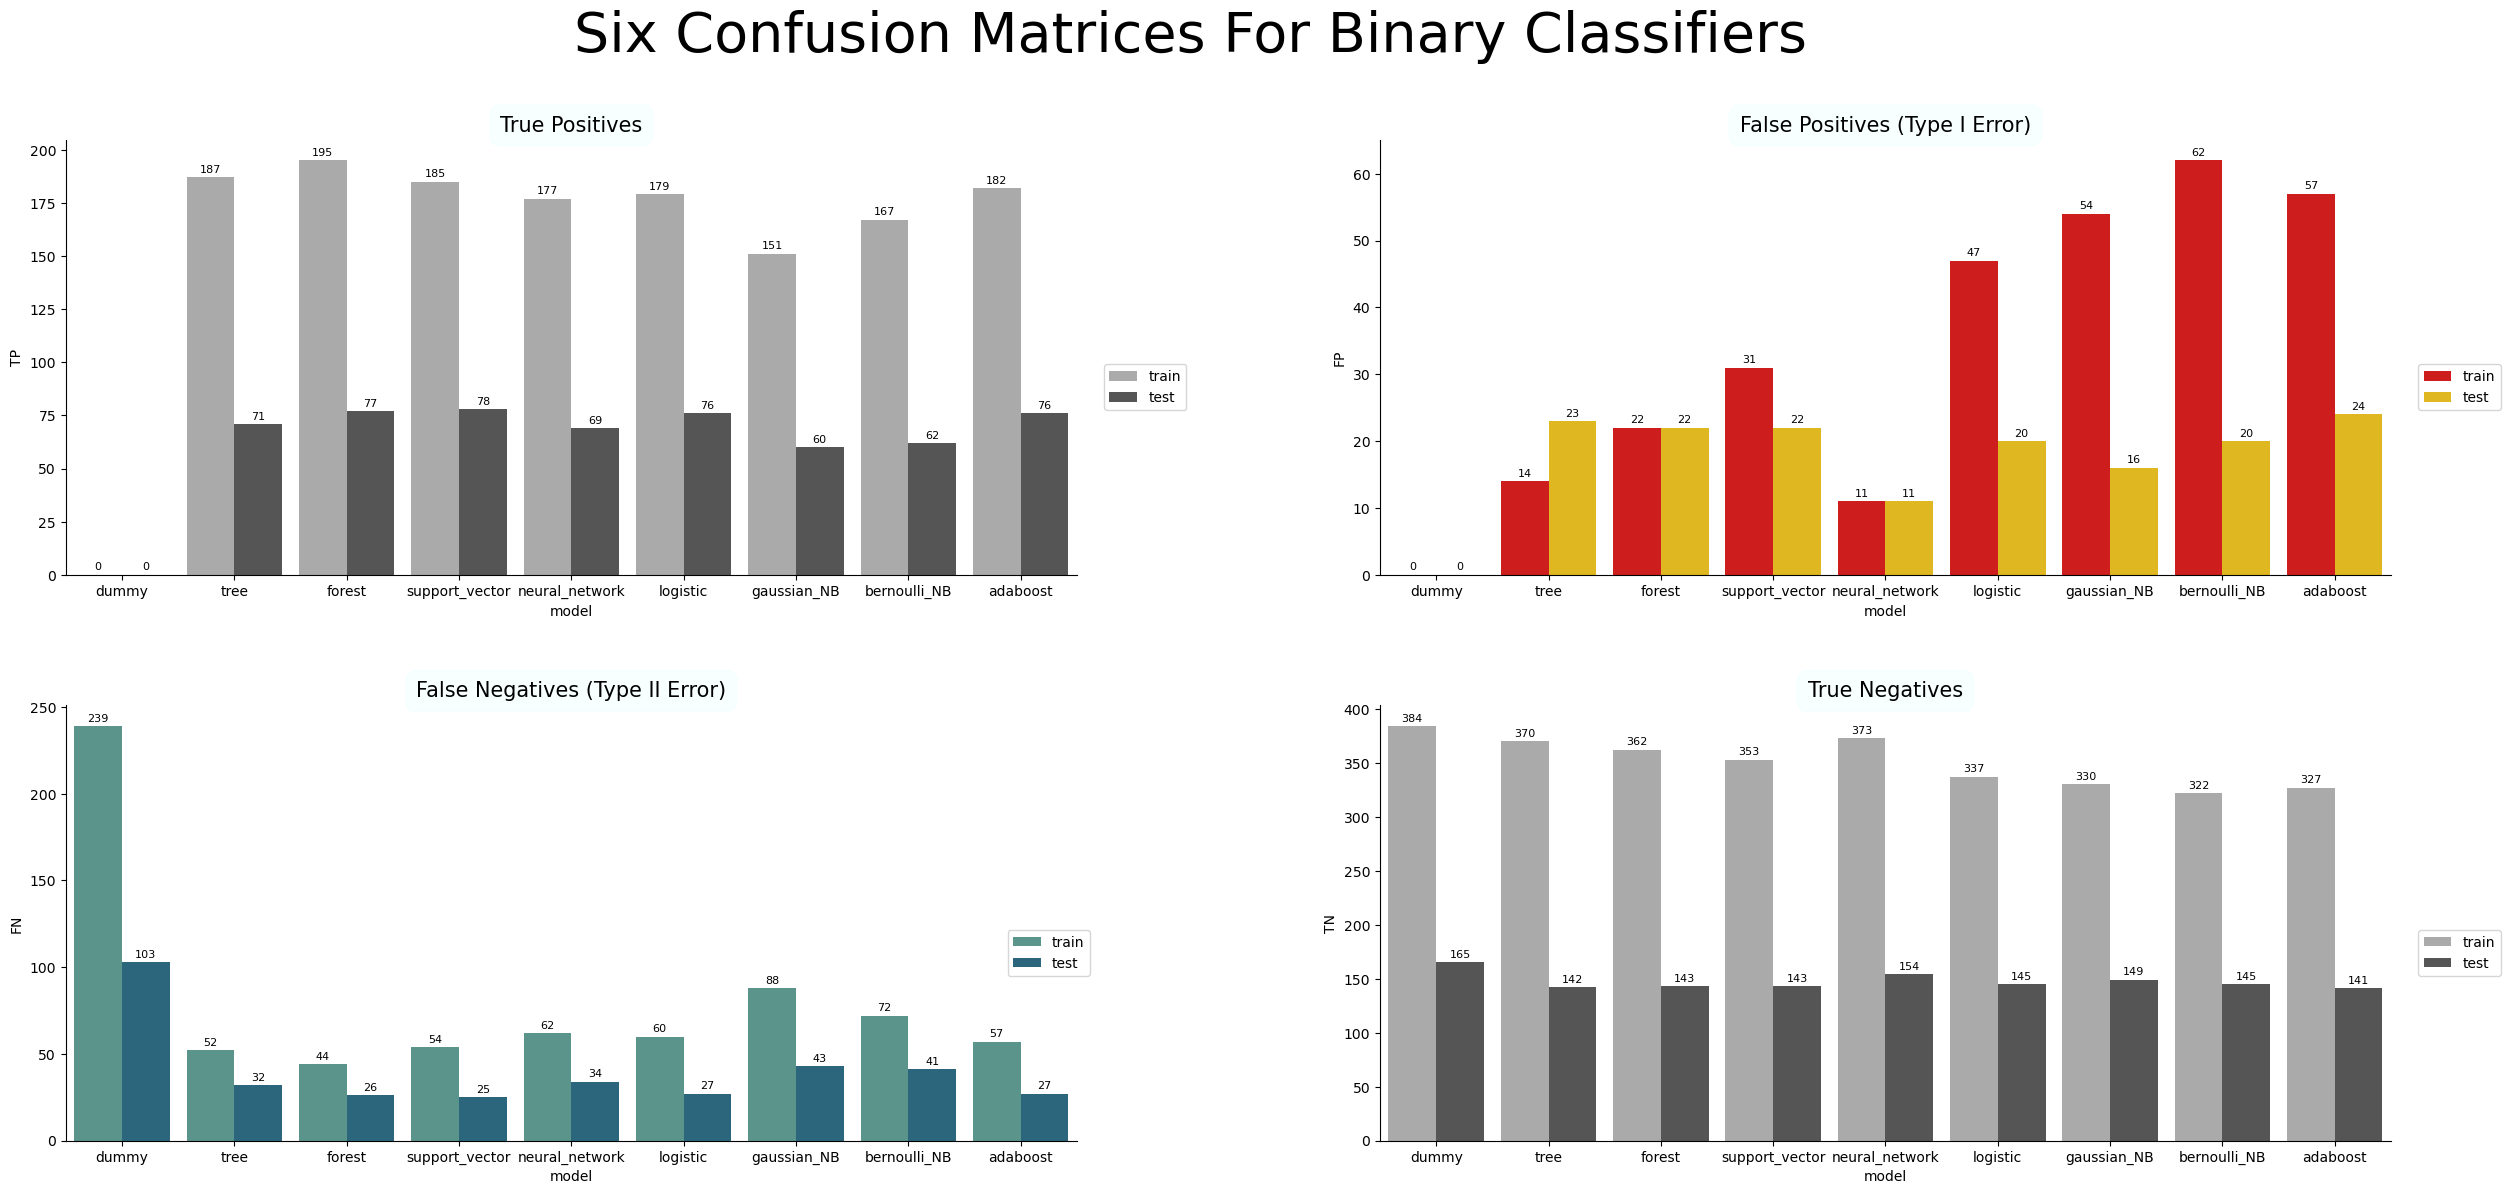

In [9]:
helpers.plot_confusion_matrices(confusion_matrices_df)

The distinction between the `support_vector` model and the `logistic` model during testing may not be immediately apparent. However, a closer examination reveals an interesting pattern. The `support_vector` model tends to capture more TP while also generating more FP, whereas the `logistic` model shows a preference for TN while occasionally misclassifying some instances as FN. What makes this observation particularly intriguing is the fact that both models achieve the same overall "profit" in terms of their predictive performance, yet their "balance sheets" diverge significantly. This analogy highlights the contrasting priorities of the models when it comes to classification, hinting at a trade-off when selecting one model over the other. Moreover, this trade-off appears to be intricately connected to the occurrences of FP and FN, as suggested by the visualization provided.

In our study, the role of false positives and false negatives is of utmost importance. Evaluating the accuracy of a model, as measured by the formula:

<img src = "https://latex.codecogs.com/svg.image?\mbox{Accuracy}&space;=&space;\frac{TP&space;&plus;&space;TN}{TP&space;&plus;&space;FP&space;&plus;&space;FN&space;&plus;&space;TN},"/>

provides an overall assessment of a model's capability to minimize both FP and FN. This explains why differentiating the `support_vector` model from the `logistic` model based solely on their accuracy scores is challenging, as the differences in their FP and FN tend to cancel out in the formula. So, are there other metrics that can effectively measure a model's ability to minimize FP and FN?

Indeed, the confusion matrix provides a great source of metrics for this purpose. Presented below is a table showcasing these metrics:

<table style = "width:40%">
    
  <tr>
    <th style="text-align: center">Metric</th>
    <th style="text-align: center">Formula</th>
    <th style="text-align: center">Minimizing</th>
  </tr>
    
  <tr>
    <td style="text-align: center">True Positive Rate (Sensitivity)</td>
    <td style="text-align: center"> <img src = "https://latex.codecogs.com/svg.image?&space;\mbox{TPR}&space;=&space;\frac{TP}{TP&space;&plus;&space;FN}"/></td>
    <td style="text-align: center">FN</td>
  </tr>
    
  <tr>
    <td style="text-align: center">Negative Predictive Value</td>
    <td style="text-align: center"><img src = "https://latex.codecogs.com/svg.image?\mbox{NPV}&space;=&space;\frac{TN}{TN&space;&plus;&space;FN}"/></td>
    <td style="text-align: center">FN</td>
  </tr>
    
  <tr>
    <td style="text-align: center">True Negative Rate (Specifity)</td>
    <td style="text-align: center"><img src = "https://latex.codecogs.com/svg.image?\mbox{TNR}&space;=&space;\frac{TN}{TN&space;&plus;&space;FP}"/></td>
    <td style="text-align: center">FP</td>
  </tr>
    
  <tr>
    <td style="text-align: center">Positive Predictive Value</td>
    <td style="text-align: center"><img src = "https://latex.codecogs.com/svg.image?\mbox{PPV}&space;=&space;\left\{&space;\begin{array}{cl}\frac{TP}{TP&space;&plus;&space;FP}&space;&&space;\mbox{if&space;$TP&space;&plus;&space;FP&space;\not=&space;0$,}&space;\\0&space;&&space;\mbox{if&space;else.}\end{array}&space;\right."/></td>
    <td style="text-align: center">FP</td>
  </tr>
    
  <tr>
    <td style="text-align: center">Balanced Accuracy</td>
    <td style="text-align: center"><img src = "https://latex.codecogs.com/svg.image?\mbox{BA}&space;=&space;\frac{1}{2}&space;\left(&space;\frac{TP}{TP&space;&plus;&space;FN}&space;&plus;&space;\frac{TN}{TN&space;&plus;&space;FP}&space;\right)"/></td>
    <td style="text-align: center">both FP and FN</td>
  </tr>
    
  <tr>
    <td style="text-align: center">F-score</td>
    <td style="text-align: center"><img src = "https://latex.codecogs.com/svg.image?F_1&space;=&space;\frac{2TP}{2TP&space;&plus;&space;FP&space;&plus;&space;FN}"/></td>
    <td style="text-align: center">both FP and FN</td>
  </tr>
    
</table>

A higher score for each metric indicates the corresponding minimizing ability of a model. It is important to note that we define the Positive Predictive Value as 0 when no positive class is predicted:

<img src = "https://latex.codecogs.com/svg.image?TP&plus;FP=0"/>

This is done to ensure the metric remains valid even for the `dummy` model, thereby ensuring the reliability of our study.

When it comes to programming, the metrics are defined using efficient `lambda` functions and stored in the `metrics_dict` dictionary. Accessing these metrics is made convenient through the `helpers` library by simply invoking the `helpers.metric_init function`. This well-structured approach enhances code modularity and promotes ease of use and maintenance.

In [10]:
metrics_dict: dict = {}

# Minimizing FN
# True Positive Rate = Sensitvity
# Negative Predictive Value = Precision for the Negative class
metrics_dict['TPR'] = lambda row: row['TP'] / (row['TP'] + row['FN'])
metrics_dict['NPV'] = lambda row: row['TN'] / (row['TN'] + row['FN'])

# Minimizing FP
# True negative rate (TNR)
# Positive predictive value (PPV)
metrics_dict['TNR'] = lambda row: row['TN'] / (row['FP'] + row['TN'])
metrics_dict['PPV'] = lambda row: row['TP'] / (row['FP'] + row['TP']) if (row['FP'] + row['TP']) else 0

# Balanced metric (minimizing both FN and FP)
# Balanced accuracy (BA)
# F1-score
metrics_dict['BA'] = lambda row: 1 / 2 * (row['TP'] / (row['TP'] + row['FN']) + row['TN'] / (row['TN'] + row['FP']))
metrics_dict['F1'] = lambda row: (2 * row['TP']) / (2 * row['TP'] + row['FP'] + row['FN'])
        
# #  The metrics are also available from the helpers class.
# metrics_dict = helpers.metrics_init()[0]

The use of `lambda` functions allows us to harness the vectorization feature of the `pandas` library, enabling an efficient computation of metrics for all models. This is achieved by employing the `.agg()` method.

In [11]:
metrics_df: pd.DataFrame = confusion_matrices_df

for metric, formula in metrics_dict.items():
    metrics_df[metric] = metrics_df.agg(formula, axis = 1)

print('This is the dataframe of six metrics for each models.')
display(metrics_df)

This is the dataframe of six metrics for each models.


,model,train,TN,FP,FN,TP,accuracy,TPR,NPV,TNR,PPV,BA,F1
0,dummy,1,384,0,239,0,0.616372,0.000000,0.616372,1.000000,0.000000,0.500000,0.000000
1,dummy,0,165,0,103,0,0.615672,0.000000,0.615672,1.000000,0.000000,0.500000,0.000000
2,tree,1,370,14,52,187,0.894061,0.782427,0.876777,0.963542,0.930348,0.872984,0.850000
3,tree,0,142,23,32,71,0.794776,0.689320,0.816092,0.860606,0.755319,0.774963,0.720812
4,forest,1,362,22,44,195,0.894061,0.815900,0.891626,0.942708,0.898618,0.879304,0.855263
5,forest,0,143,22,26,77,0.820896,0.747573,0.846154,0.866667,0.777778,0.807120,0.762376
6,support_vector,1,353,31,54,185,0.863563,0.774059,0.867322,0.919271,0.856481,0.846665,0.813187
7,support_vector,0,143,22,25,78,0.824627,0.757282,0.851190,0.866667,0.780000,0.811974,0.768473
8,neural_network,1,373,11,62,177,0.882825,0.740586,0.857471,0.971354,0.941489,0.855970,0.829040
9,neural_network,0,154,11,34,69,0.832090,0.669903,0.819149,0.933333,0.862500,0.801618,0.754098


The bar graphs of these metrics can be easily generated using the `plot_titanic_metrics` function from the `helpers` library. This convenient function automates the process and allows for clear and insightful visualization of the metrics. The resulting visual is organized into a 2x3 grid, with the left column displaying the FN-minimizing metrics: True Positive Rate and Negative Predictive Value. The middle column showcases the FP-minimizing metrics: True Negative Rate and Positive Predictive Value. Lastly, the right column presents the balanced metrics: Balanced Accuracy and F-score.

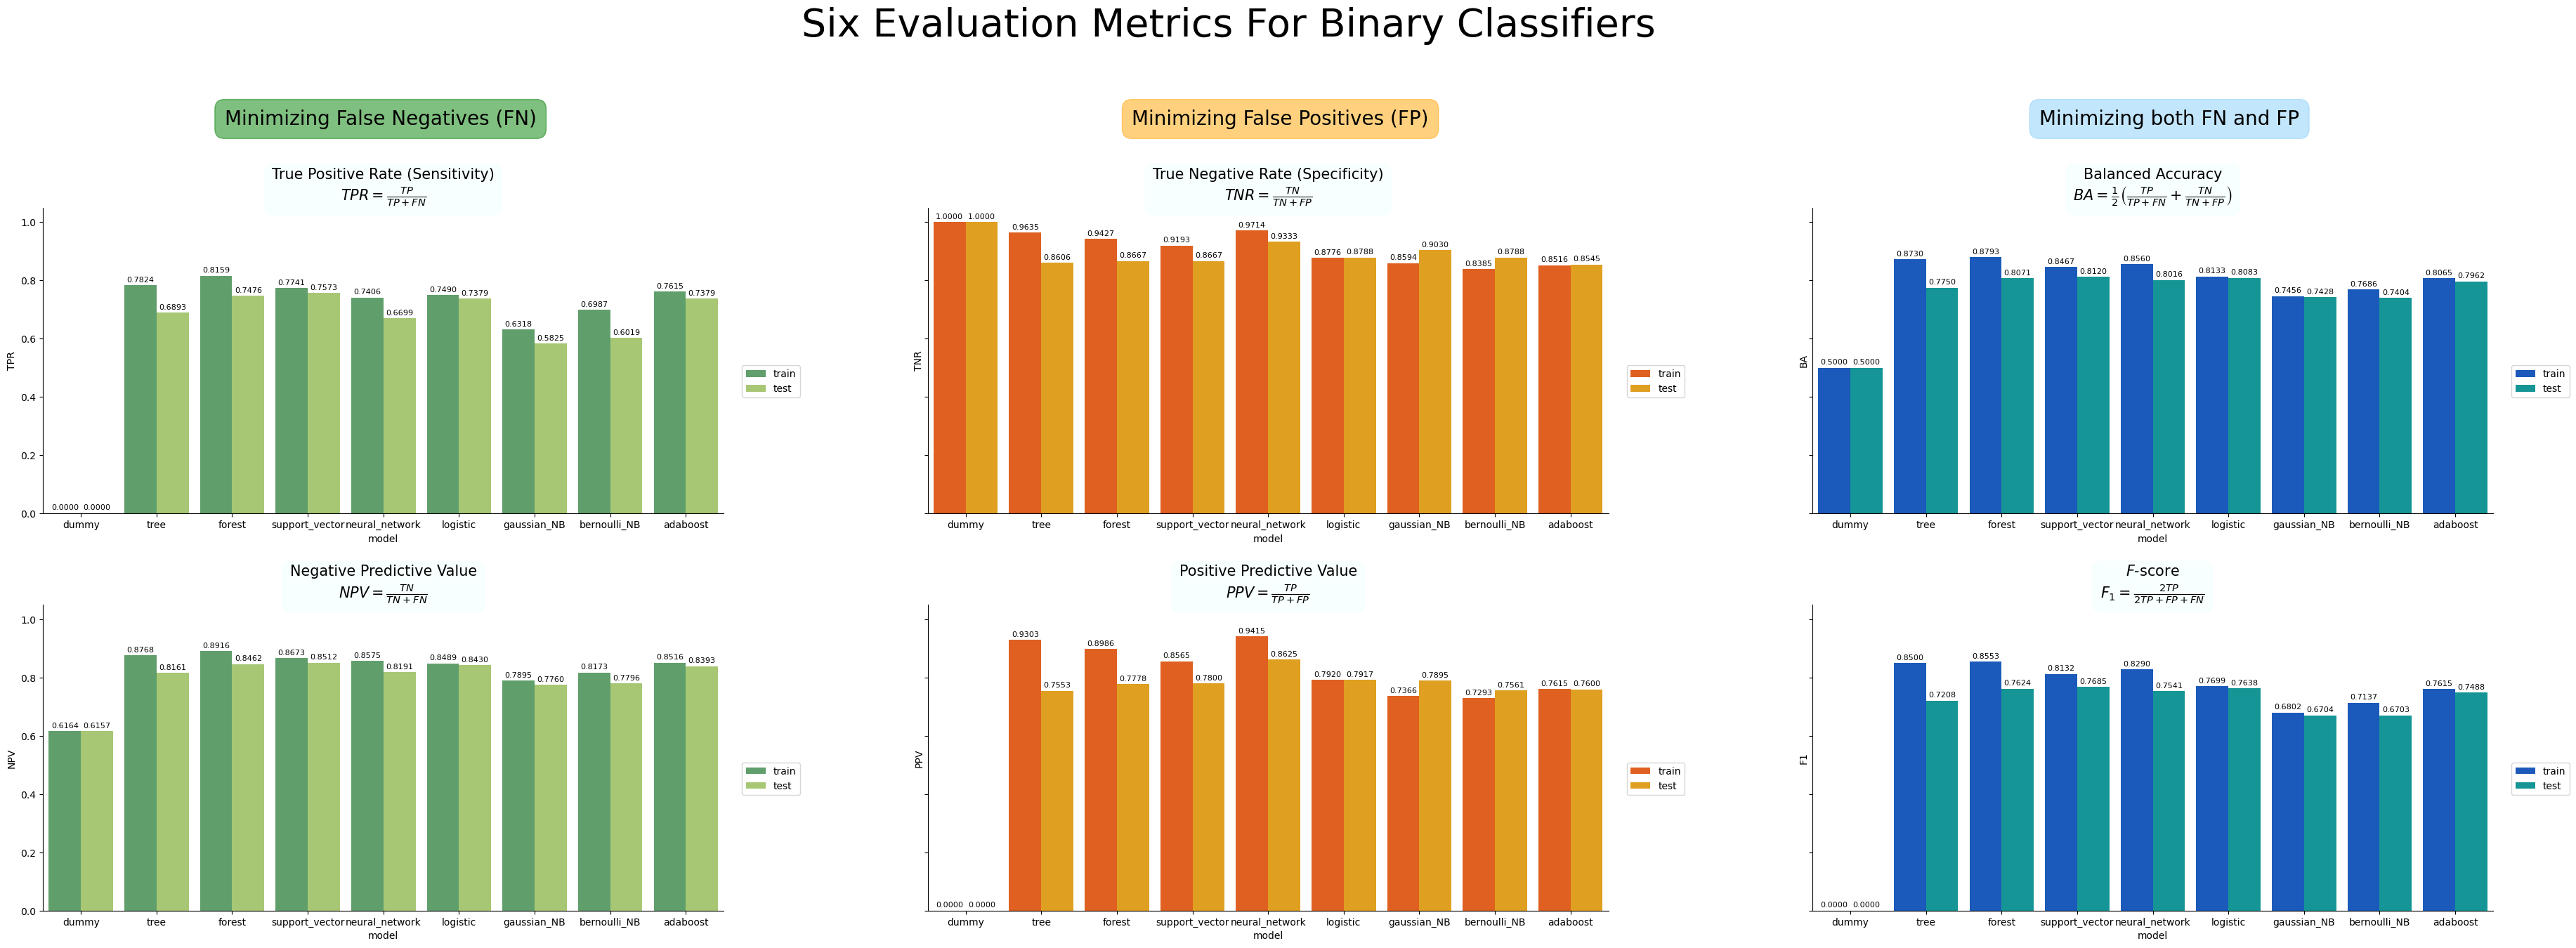

In [12]:
helpers.plot_titanic_metrics(metrics_df)

Let us begin with the left (green) column, which showcases the visuals for the metrics True Positive Rate (TPR) and Negative Predictive Value (NPV). During testing, the `support_vector` model exhibits a TPR of 0.7573, while the `logistic` model achieves a slightly lower TPR of 0.7379. Similarly, the NPV for the `support_vector` model is 0.8512, whereas the `logistic` model achieves an NPV of 0.8430. Notably, the `support_vector` model outperforms the `logistic` model by at least 0.96% on these FN-minimizing metrics.

Moving on to the middle (orange) column, we encounter the metrics True Negative Rate (TNR) and Positive Predictive Value (PPV). In testing, the `support_vector` model attains a TNR of 0.8667, while the `logistic` model surpasses it with a TNR of 0.8788. Furthermore, the `support_vector` model achieves a PPV of 0.7800, while the `logistic` model exhibits a slightly higher PPV of 0.7917. Thus, the `logistic` model demonstrates a performance advantage of at least 0.96% on these FN-minimizing metrics when compared to the `support_vector` model.

Lastly, the right (blue) column showcases the metrics Balanced Accuracy (BA) and F-score. For the `support_vector` model, the BA during testing is 0.8120, whereas the `logistic` model achieves a slightly lower BA of 0.8083. Additionally, the F-score for the `support_vector` model is 0.7685, while the `logistic` model obtains an F-score of 0.7638. Here, it is noteworthy that the `support_vector` model outperforms the `logistic` model by at least 0.46% on these balanced metrics.

It is worth mentioning that the average of all the showcased metrics is also a balanced metric.

In [13]:
metrics_df['avg'] = metrics_df[['TPR', 'NPV', 'TNR', 'PPV', 'BA', 'F1']].mean(axis = 1)

metrics_df[(metrics_df['model'].isin(['support_vector', 'logistic'])) & (metrics_df['train'] == 0)][['model', 'train', 'avg']]

,model,train,avg
7,support_vector,0,0.805931
11,logistic,0,0.803914


The `support_vector` model obtains an average metric score of 0.8059, whereas the `logistic` model exhibits a slightly lower average metric of 0.8039. This serves to emphasize the observation that the `support_vector` model excels in minimizing both FP and FN, even when subjected to a more rigorous evaluation criterion.

At this point, we can draw some conclusions from these findings. The results suggest that the `support_vector` model exhibits superior performance in minimizing FN, while the `logistic` model demonstrates better capabilities in minimizing FP. However, it is important to note that there is no natural priority between minimizing FP and minimizing FN in our case, as as both objectives are equally important. Therefore, it is crucial to consider balanced metrics that effectively minimize both FP and FN.

In summary, the `support_vector` model outperforms the `logistic` model in effectively minimizing both FP and FN. This observation holds true despite both models achieving the same accuracy score. As a result, the `support_vector` model is the preferred choice for the Kaggle competition.

To validate our analysis, we can proceed by submitting predictions to the Kaggle competition, and assess the performance of the models in a real-world scenario.

<h2>Kaggle Submission Results</h2>

In our previous analysis, we drew two major conclusions:

1. Overfitting: The `tree`, `forest`, and `neural_network` models exhibit clear signs of overfitting, which indicates that they are not generalizing well to unseen data. This finding raises concerns about their reliability and effectiveness in real-world scenarios.
2. Top Performer: The `support_vector` model stands out as a highly reliable and competent model, showcasing the potential to outperform other models in the Kaggle competition.

In this section, we will assess these conclusions using the Kaggle submission results.

To evaluate the models' performance objectively, we submitted predictions on the testing set to Kaggle. This testing set `csv/test_cleaned.csv` is a cleaned version of the original `csv/test.csv` file provided by Kaggle. We encourage readers to refer to the `demo_titanic_data_cleaning.ipynb` file for detailed insights into our data cleaning process.

The final performance of each model, as obtained from the Kaggle submission page, is displayed below:

<img src = "images/[submission_result][20230517].png" width="800" height="600" />

The submissions were made on May 17, 2023. Although the submission for the `dummy` model was made three days later, this delay does not impact the rankings or relative performance of the models.

The Kaggle submission results can be found in the `csv/data/final_submission_accuracy.csv` file

In [14]:
final_submission_df: pd.DataFrame = pd.read_csv('csv/data/final_submission_accuracy.csv')

print('These are the Kaggle submission results.')
display(final_submission_df[final_submission_df['train'] == 2])

These are the Kaggle submission results.


,model,train,accuracy
18,dummy,2,0.62200
19,tree,2,0.75358
20,forest,2,0.76555
21,support_vector,2,0.78947
22,neural_network,2,0.75837
23,logistic,2,0.77511
24,gaussian_NB,2,0.71531
25,bernoulli_NB,2,0.73444
26,adaboost,2,0.76315


and the `helpers.plot_Kaggle_results` function generates a bar graph to visualize the Kaggle accuracies.

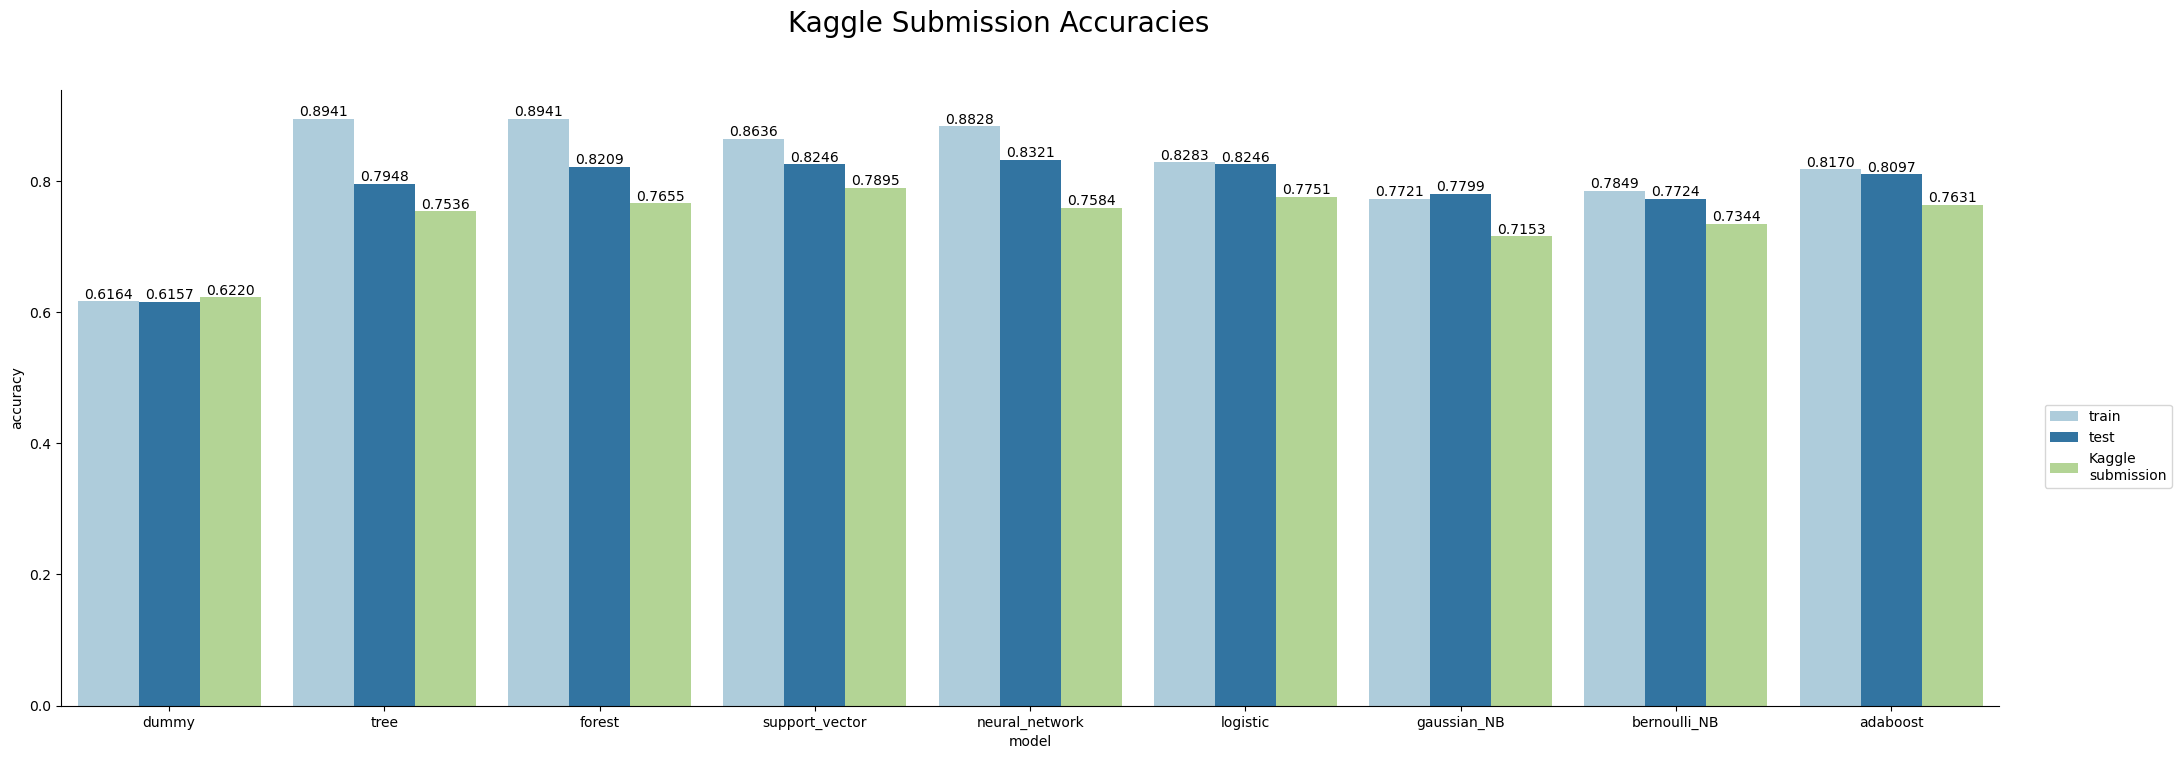

In [15]:
helpers.plot_Kaggle_results(final_submission_df)

Based on the Kaggle submission results, the `support_vector` model achieves the highest Kaggle accuracy score of 0.78947. The `logistic` model follows closely with a score of 0.77511, making it the first-runner up. The `forest` model comes in third with an accuracy of 0.76555, followed by `adaboost` (0.76315), `neural_network` (0.75837), `tree` (0.75358), `bernoulli_NB` (0.73444), and `gaussian_NB` (0.71531). Notably, the `dummy` model has the lowest Kaggle accuracy score of 0.622.

When comparing the testing accuracy to the Kaggle submission accuracy, we observe the most significant drop in model performance for the `neural_network` model, with a decrease of 8.9%. The `gaussian_NB` model follows with a decrease of 8.3%, followed by `forest` (6.7%), `logistic` (6.0%), `adaboost` (5.7%), `tree` (5.2%), `bernoulli_NB` (4.9%), and `support_vector` model (4.3%). Interestingly, the `dummy` model performs 1.0% better in the Kaggle submission stage, although this difference is not significant.

We observe a rapid decline in model performance for the `forest`, and `neural_network` models when comparing their testing and Kaggle submission accuracies. The confidence intervals for the testing accuracy of these models do not contain the Kaggle accuracies, indicating a more severe overfitting problem. In contrast, the confidence interval for testing accuracy of the `tree` model contains the Kaggle accuracy, suggesting coherence between the testing and Kaggle submission stages. However, this does not mitigate its overfitting problem, as indicated by its high training accuracy. These results support our previous observation that the `tree`, `forest`, and `neural_network` models exhibit signs of overfitting.

On the other hand, the `support_vector` model, which achieved the highest Kaggle accuracy score, displayed coherence between the testing and Kaggle submission stages. The confidence interval for its testing accuracy encompassed the Kaggle accuracy, further reinforcing its reliability as a superior model. These results support our previous observation that the `support_vector` model is the top performer.


<h2>Conclusion</h2>

In conclusion, we evaluated nine machine learning models on their ability to predict Titanic passenger survival, with the goal of identifying a reliable model that outperforms the rest in the Kaggle competition. Although the neural network model had the highest testing accuracy, it was marked as overfitted based on hypothesis testing. The support vector classifier and logistic regression classifier shared the second-highest testing accuracy, resulting in a tie.  However, an in-depth analysis of confusion matrices favored the support vector classifier due to its superior performance in minimizing false positives and false negatives.

The submission of predictions to the Kaggle competition validated our conclusions. The observed results align with our earlier findings, confirming the presence of overfitting in the decision tree classifier, random forest classifier , and the neural network model, while highlighting the superiority of the support vector classifier.

These findings highlight the importance of addressing overfitting issues and selecting appropriate models to achieve optimal performance in machine learning.